# Nortek AD2CP Processing, Testing, and Data Exploration

jgradone@marine.rutgers.edu     01/11/2022    Initial

**This Jupyter Notebook is intended to:**<br>
1) Read glider data frome ERDDAP <br>
2) Read in AD2CP data processed to NetCDFs using the Nortek MIDAS software as an xarray DataSet and combine all into one massive DataSet <br>
3) Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data <br>
4) Correct for local speed of sound <br>
5) QAQC AD2CP data <br>
6) Correct beams to level true-depth <br>
7) Bin map AD2CP data <br>
8) AD2CP Coordinate transformation from beam to XYZ to ENU <br>
9) Least squares linear inversion on ADCP velocities referenced to true ocean velocity through a depth averaged urrent constraint <br>
10) Save output from each segment<br>


*Details/comments on what the functions are actually doing in the source code*

In [63]:
# Imports
import scipy.interpolate as interp
from scipy.sparse.linalg import lsqr, lsmr
from scipy.sparse.linalg import inv
from scipy import integrate
import scipy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import netCDF4 as nc
import math
import datetime
import xarray as xr
import matplotlib.dates as mdates
import dask.array as da
from erddapy import ERDDAP
from netCDF4 import Dataset
import gsw
#import cmocean.cm as cmo
import sys
from datetime import datetime
import time


## To import functions from Slocum-AD2CP GitHub repository, make this path the path to where the repo exists locally
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/analysis/')
sys.path.insert(0,'/home/jg1200/GitHub/Slocum-AD2CP/src/data/')
sys.path.insert(0,'/home/jg1200/Code/Functions/loess/')
from make_dataset import correct_sound_speed, beam_true_depth, cell_vert, binmap_adcp, beam2enu, inversion, qaqc_pre_coord_transform, qaqc_post_coord_transform
from analysis import get_erddap_dataset
import loess_1d

## Set some plotting formats
plt.style.use('seaborn-poster')
myFmtshort = mdates.DateFormatter('%m/%d\n%H:%M')
myFmtlong = mdates.DateFormatter('%m/%d/%y \n%H:%M')
myFmt = mdates.DateFormatter('%m/%d/%y')

## Step 1: Load glider data

In [64]:
#ds_id = 'ru29-20210908T1943-trajectory-raw-delayed'
ds_id = 'ru29-20210630T1343-trajectory-raw-delayed'


## Load flight data
variables = ['depth', 'latitude', 'longitude', 'time', 'sci_water_temp', 'sci_water_cond','source_file', 'm_water_vx', 'm_water_vy', 'm_heading']
gdf = get_erddap_dataset(ds_id, server='http://slocum-data.marine.rutgers.edu/erddap', variables = variables, filetype='dataframe')
gdf.columns = variables

## Great way to find start and end times!!
start_times = gdf.groupby('source_file').first().time.values
end_times   = gdf.groupby('source_file').last().time.values
## Remove time zone for slicing ad2cp times
start_times2 = pd.to_datetime(start_times).tz_localize(None)
end_times2 = pd.to_datetime(end_times).tz_localize(None)

gdf

# x=10
# plt.plot(gdf.depth[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])])

,depth,latitude,longitude,time,sci_water_temp,sci_water_cond,source_file,m_water_vx,m_water_vy,m_heading
0,0.000000,18.170740,-64.831853,2021-06-30T13:43:52Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
1,NaN,18.170740,-64.831853,2021-06-30T13:43:57Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
2,0.000000,18.170740,-64.831853,2021-06-30T13:43:57Z,0.0000,0.00000,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
3,NaN,18.170740,-64.831853,2021-06-30T13:44:54Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),-0.100307,0.03465,2.53247
4,NaN,18.170465,-64.834150,2021-06-30T13:45:20Z,NaN,NaN,ru29-2021-180-3-0-dbd(04570000),NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
732984,0.238559,18.164417,-63.468548,2021-07-12T12:53:52Z,28.1624,5.63906,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732985,0.198799,18.164417,-63.468548,2021-07-12T12:53:54Z,28.1629,5.63894,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732986,0.178920,18.164417,-63.468548,2021-07-12T12:53:56Z,28.1619,5.63898,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN
732987,0.198799,18.164417,-63.468548,2021-07-12T12:53:58Z,28.1565,5.63899,ru29-2021-192-0-9-dbd(04620009),NaN,NaN,NaN


## Step 2: Load in AD2CP data frame

In [65]:
path = '/home/jg1200/Data/GliderData/RU29/RU29_2021_Mission_1_AD2CP_NC/'
files = np.sort(glob.glob(path+'*.nc'))

tot_ad2cp = xr.open_mfdataset(files,group='Data/Burst/', concat_dim="time", combine="nested")
## I think this is a documented bug in the xarray open_mfdataset function for grouped NetCDFs
config = xr.open_dataset(files[0],group='Config')
## So, just assigning the global attributes from the first file to the combined file
tot_ad2cp = tot_ad2cp.assign_attrs(config.attrs)
tot_ad2cp = tot_ad2cp.rename({'Velocity Range':'VelocityRange','Correlation Range':'CorrelationRange','Amplitude Range':'AmplitudeRange'})
# 2 House-keeping steps
# 1) Roll shifted 180 for some reason
tot_ad2cp['Roll'] = tot_ad2cp['Roll']-180
# 2) Surface depth is 10 meters. Needed for at least for the 2020 and both 2021 deployments, per conversations with Sven from Nortek.
tot_ad2cp['Pressure'] = tot_ad2cp['Pressure']-10
# Put time on x-dimension
tot_ad2cp = tot_ad2cp.transpose()
tot_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 3752193, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-09T01:36:06.9070...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/52)
    VelocityBeam1              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam2              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam3              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    VelocityBeam4              (VelocityRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 22049), meta=np.ndarray>
    ...                         ...
    QuaternionX                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    QuaternionY                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    QuaternionZ                (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroX                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroY                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
    AHRSGyroZ                  (time) float32 dask.array<chunksize=(22049,), meta=np.ndarray>
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

In [107]:
tot_ad2cp.VelocityBeam1.shape

(40, 3752193)

## Step 3: Subset datasets
Pull out just one glider segment (based on a unique file name) and the corresponding dead-reckoned depth average current. Use the start and end times to subset the AD2CP data

In [138]:
## Just one file for testing
#x = -2 ## Good single 500 meter dive
x=141 ## Good single 1000 meter dive
#x=154
#x=103


## Subset glider df to one segment
subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
## Pull out last non-NaN DAC
ind         = np.argwhere(np.isnan(subsetgdf.m_water_vx).ravel()==False).flatten()
vx          = subsetgdf.m_water_vx.iloc[ind[-1]]
vy          = subsetgdf.m_water_vy.iloc[ind[-1]]
vx_lon      = np.nanmean(subsetgdf.longitude)
vx_lat      = np.nanmean(subsetgdf.latitude)
vx_start_tm = subsetgdf.time.iloc[0]
vx_end_tm   = subsetgdf.time.iloc[-1]

## Subset AD2CP dataframe based on segment start and end times
ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])

## Take a quick peak at some data

/tmp/ipykernel_26280/2703616999.py:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])


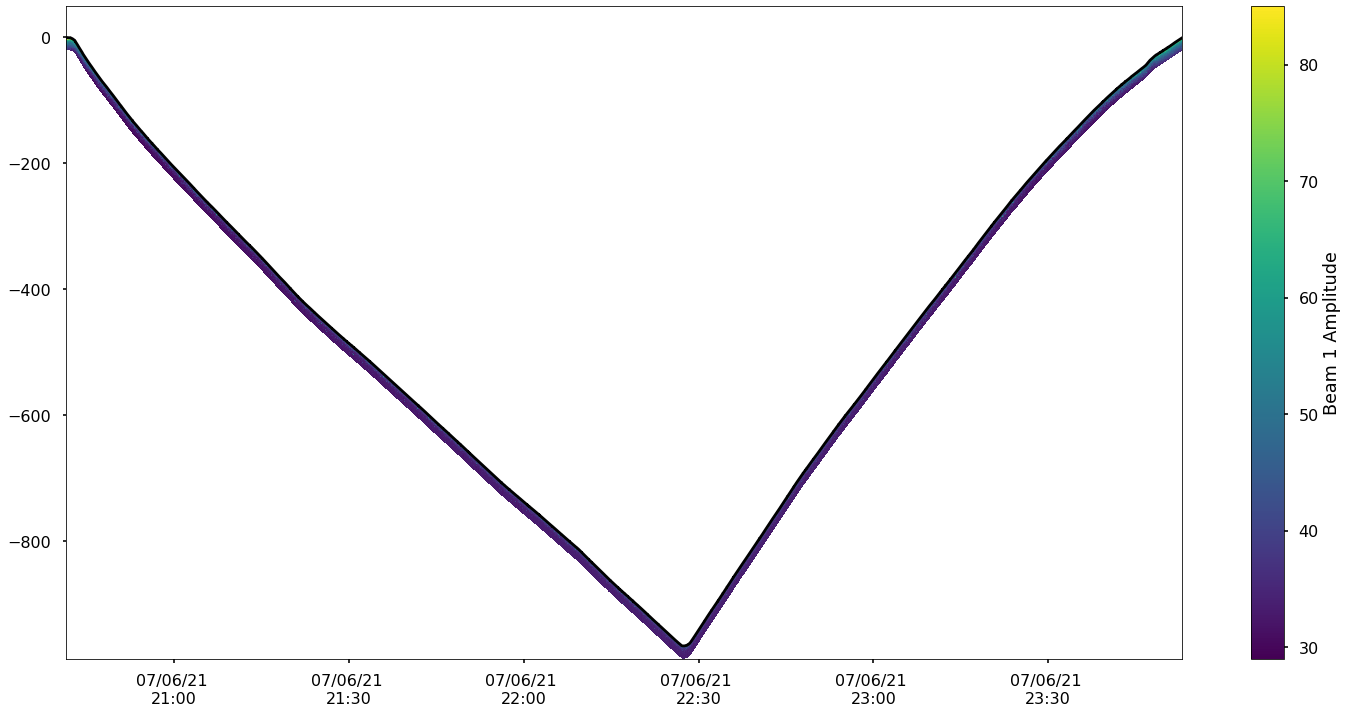

In [139]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

fig = plt.figure(figsize=(25,12))

plt.pcolormesh(x,-by,subset_ad2cp['AmplitudeBeam1'])
plt.plot(subset_ad2cp['time'],-subset_ad2cp['Pressure'],'k')
plt.colorbar(label='Beam 1 Amplitude')
plt.gca().xaxis.set_major_formatter(myFmtlong)

### Zoomed in peak at data

/tmp/ipykernel_26280/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


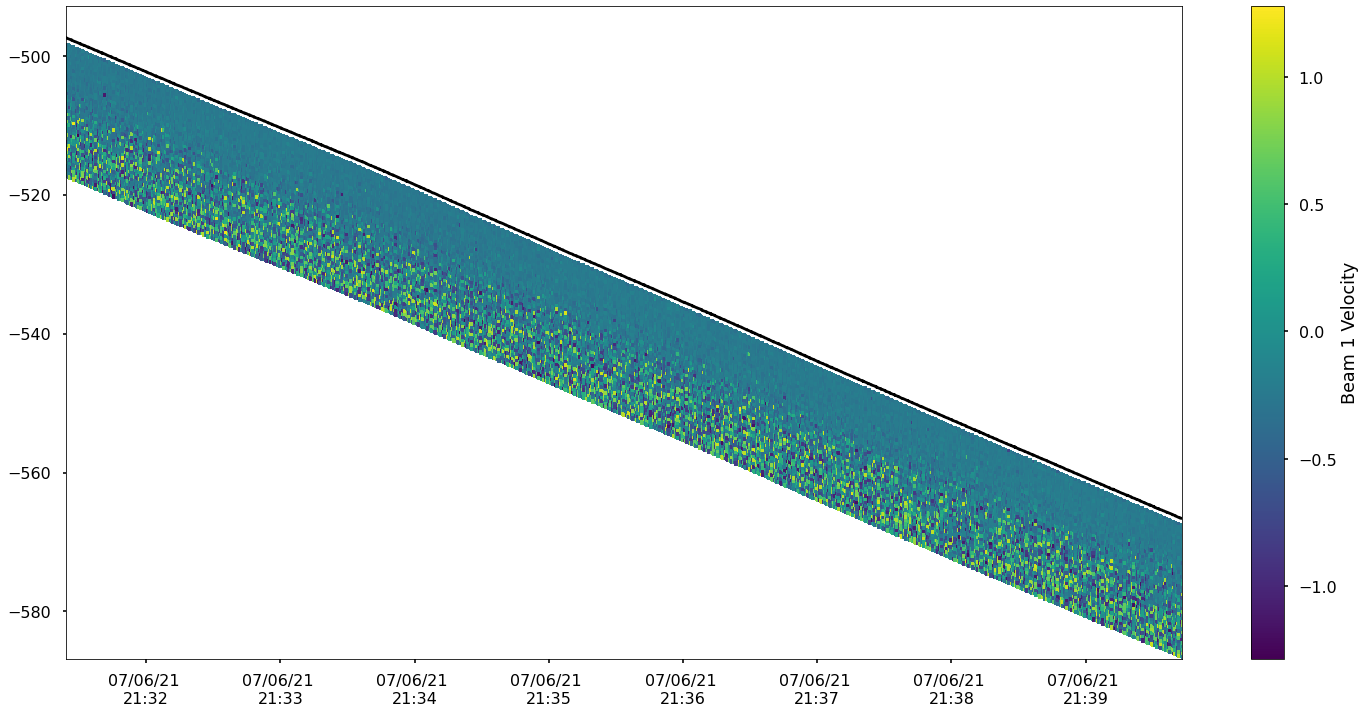

In [140]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Test ensemble averaging function
### This definitely works!

In [177]:
# def ensembe_average(ds,secs):
#     ds = ds.resample(time=secs).mean(keep_attrs=True)
#     ds = ds.transpose()
#     return(ds)

# subset_ad2cp = ensembe_average(subset_ad2cp,secs='15S')
# subset_ad2cp

In [142]:
subset_ad2cp.VelocityBeam1.shape

(40, 767)

/tmp/ipykernel_26280/2626724876.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


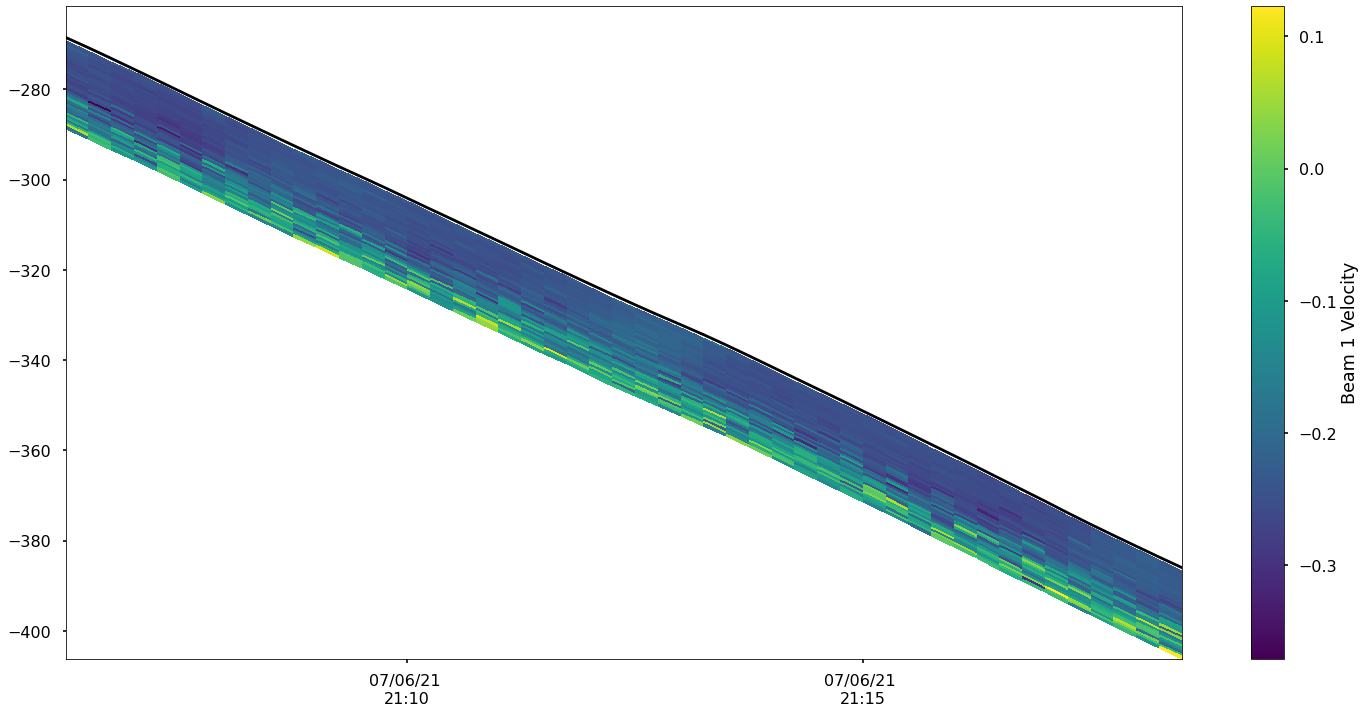

In [143]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 100
end_ind   = 150

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Step 4: Correct for local speed of sound (Fischer and Visbeck, 1993)
Where C is the real sound speed at the transducer, and CA is the speed of sound used by the ADCP. CA used by the Nortek AD2CP is 1500 m/s.

In [144]:
np.max(subset_ad2cp.VelocityBeam1.values)

0.26742858

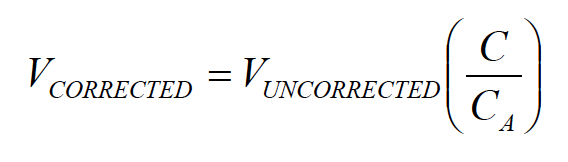

In [145]:
## Correct for local speed of sound
#subset_ad2cp = correct_sound_speed(subset_ad2cp)

In [146]:
np.max(subset_ad2cp.VelocityBeam1.values)

0.26742858

### Take a peak at the speed of sound corrected data

/tmp/ipykernel_26280/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


ValueError: zero-size array to reduction operation minimum which has no identity

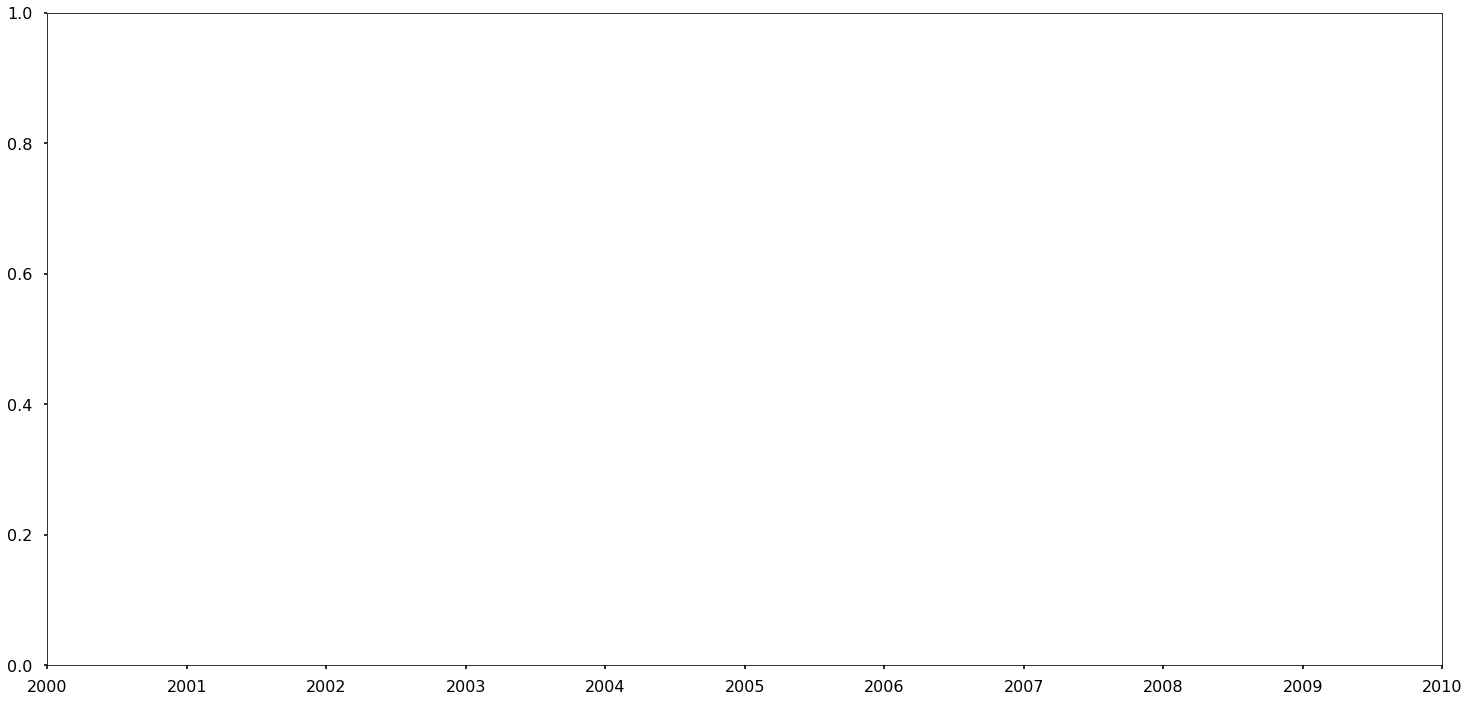

In [147]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Step 5: Filter for Extreme Amplitude Returns and Below 0.5 Correlation (Todd et al. 2017)

In [148]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

-0.18722928

In [151]:
## QAQC pre-coordinate transformation
subset_ad2cp = qaqc_pre_coord_transform(subset_ad2cp, corr_threshold = 50, max_amplitude = 75)

In [152]:
np.nanmean(subset_ad2cp.VelocityBeam1.values)

-0.24053565

### Take a peak at the QAQC'd data

/tmp/ipykernel_26280/1563067960.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])


ValueError: zero-size array to reduction operation minimum which has no identity

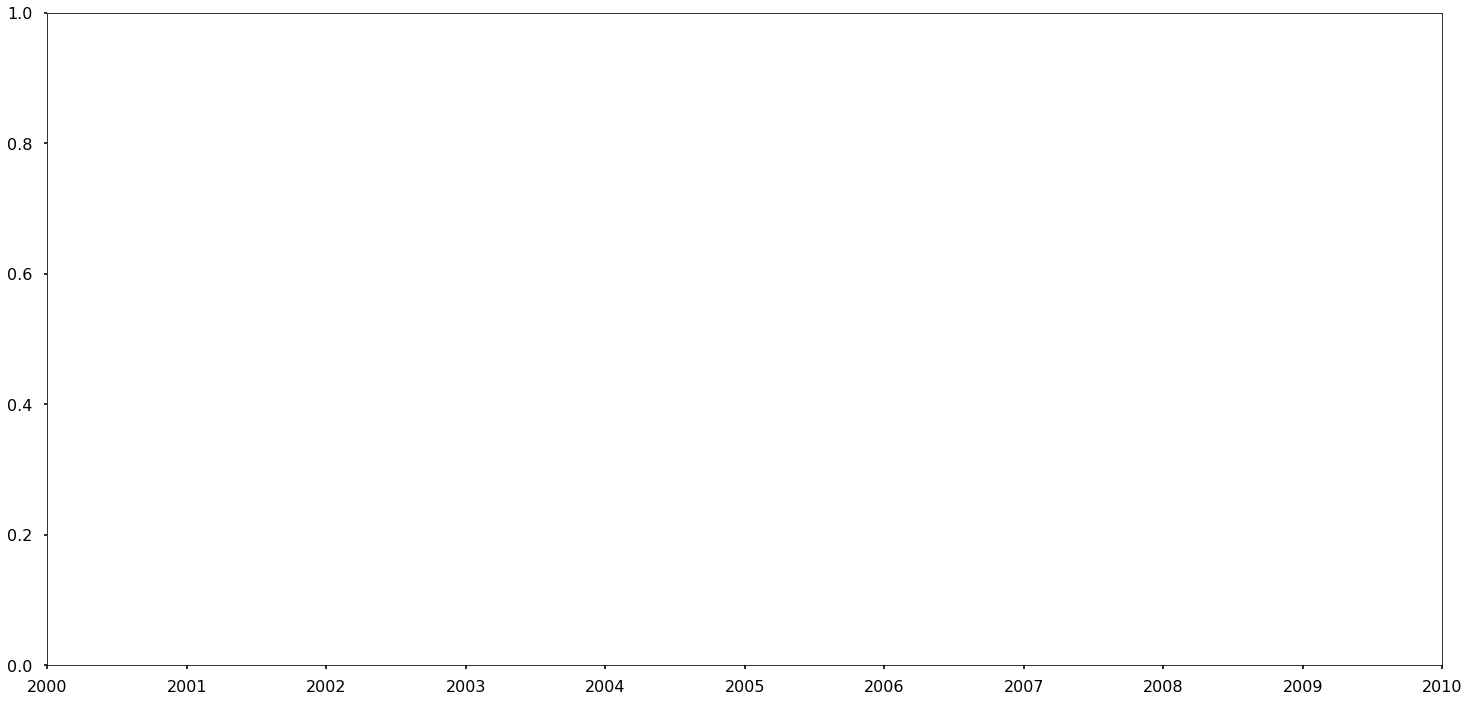

In [153]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

# start_ind = 500
# end_ind   = 850

start_ind = 12000
end_ind   = 14000


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['CorrelationBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar()
#plt.colorbar(label='Beam 1 Correlation')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_26280/4140484901.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])


ValueError: zero-size array to reduction operation minimum which has no identity

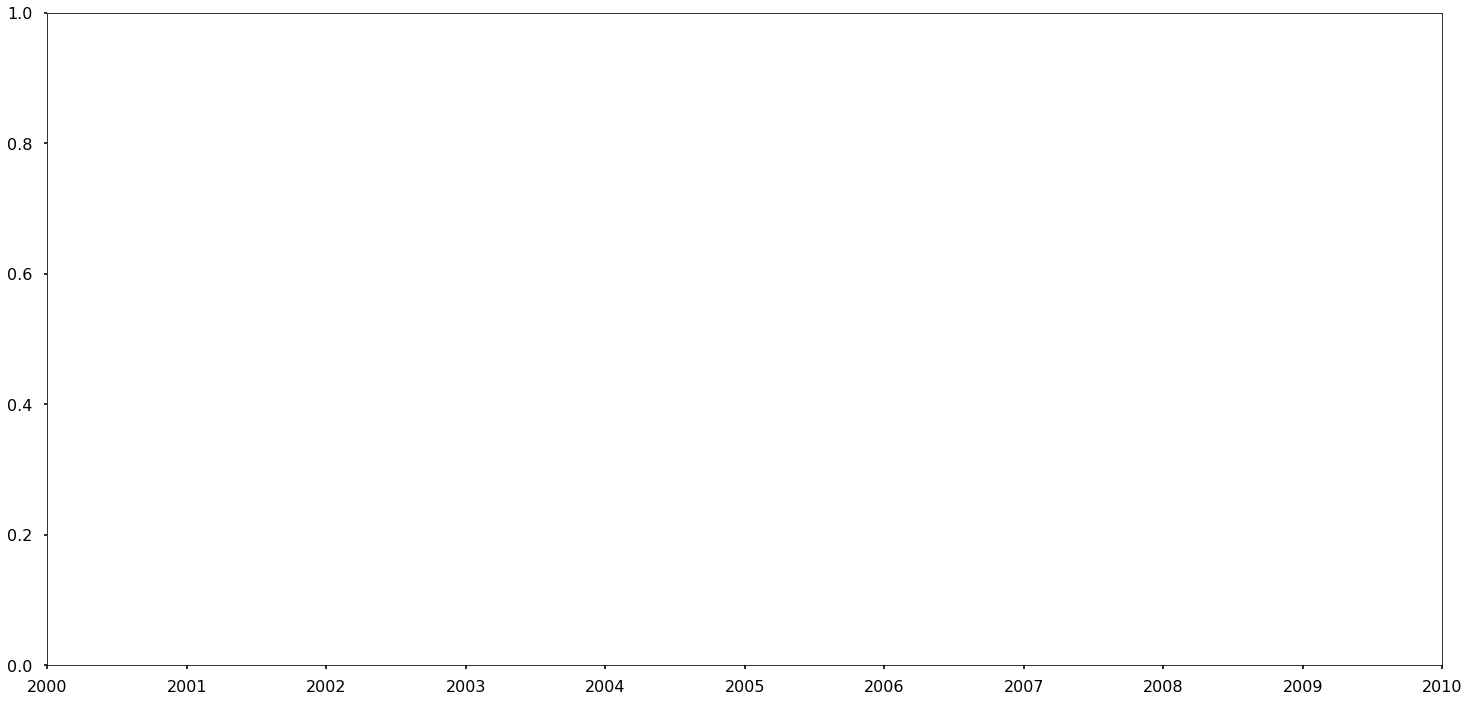

In [154]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 14000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 6: Correct beams to level true-depth

In [155]:
## Correct beams to level true-depth
subset_ad2cp = beam_true_depth(subset_ad2cp)

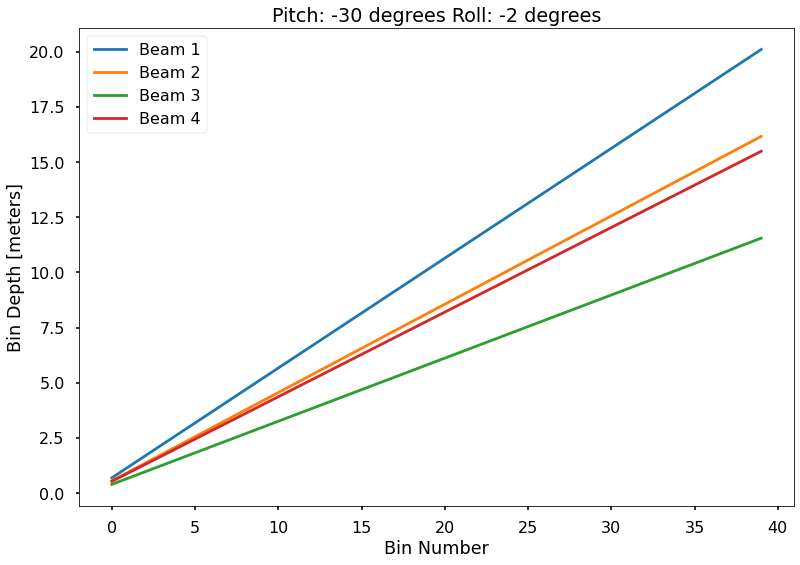

In [156]:
x=20
plt.plot(subset_ad2cp.TrueDepthBeam1.values[:,x],label='Beam 1')
plt.plot(subset_ad2cp.TrueDepthBeam2.values[:,x],label='Beam 2')
plt.plot(subset_ad2cp.TrueDepthBeam3.values[:,x],label='Beam 3')
plt.plot(subset_ad2cp.TrueDepthBeam4.values[:,x],label='Beam 4')
plt.ylabel('Bin Depth [meters]')
plt.xlabel('Bin Number')
plt.title('Pitch: %i' %subset_ad2cp['Pitch'].values[x] + ' degrees Roll: %i' %subset_ad2cp['Roll'].values[x] + ' degrees')
plt.legend()

## Processing Step 7: Bin Mapping
Interpolate to set depth grid, this will also effectively filter out extreme pitch and roll

In [157]:
## Bin map
subset_ad2cp = binmap_adcp(subset_ad2cp)

In [158]:
subset_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 767, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-06T20:41:15 ... ...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/61)
    VelocityBeam1              (VelocityRange, time) float32 nan nan ... -0.1502
    VelocityBeam2              (VelocityRange, time) float32 nan nan ... 0.07409
    VelocityBeam3              (VelocityRange, time) float32 nan nan ... 0.1948
    VelocityBeam4              (VelocityRange, time) float32 nan nan ... 0.1069
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    ...                         ...
    TrueDepthBeam4             (VelocityRange, time) float64 0.1008 ... 15.54
    TrueDepth                  (VelocityRange, time) float64 1.015 1.1 ... 21.99
    InterpVelocityBeam1        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam2        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam3        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam4        (VelocityRange, time) float64 0.09645 nan ... nan
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

### Take a peak at the bin mapped data

/tmp/ipykernel_26280/2288300711.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])


ValueError: zero-size array to reduction operation minimum which has no identity

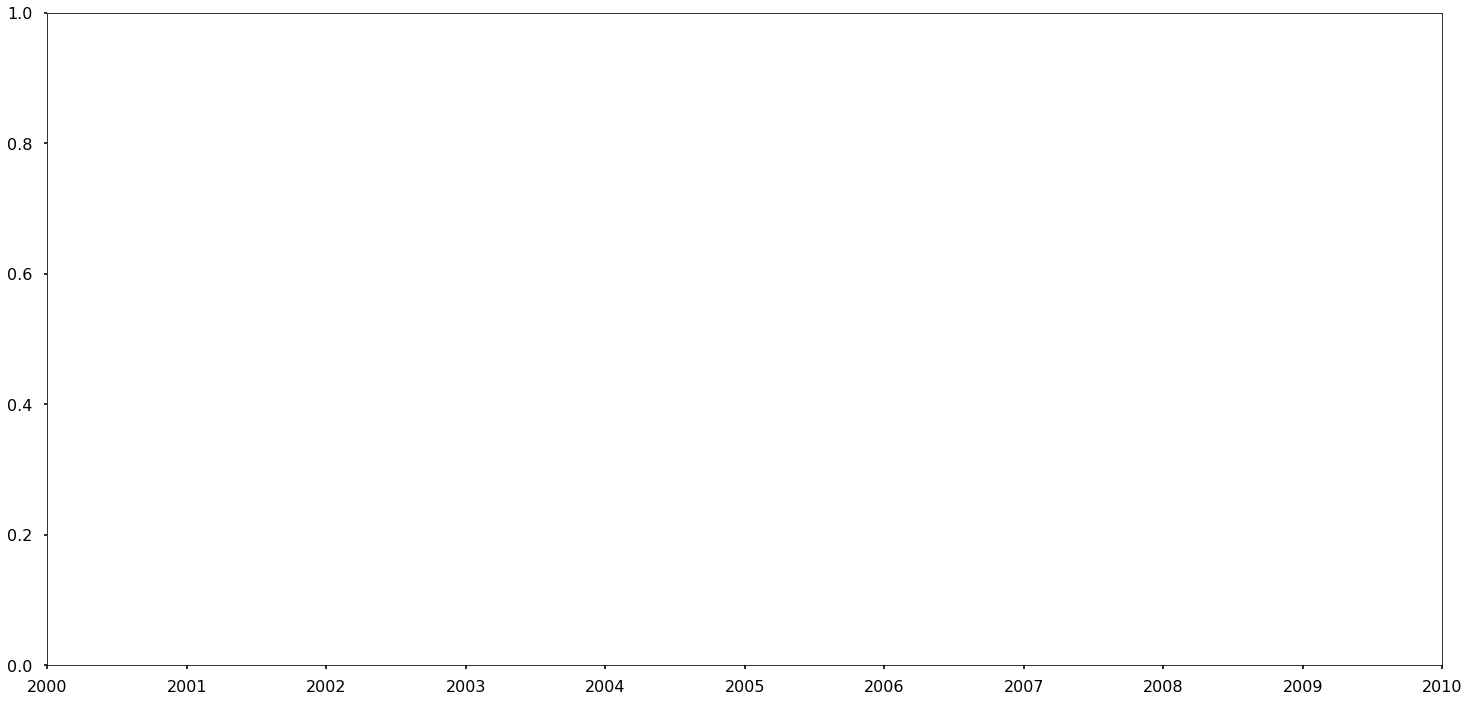

In [159]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 12000
end_ind   = 12500

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['InterpVelocityBeam1'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='Bin Mapped Beam 1 Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 8: Convert from Beam to XYZ to ENU coordinates

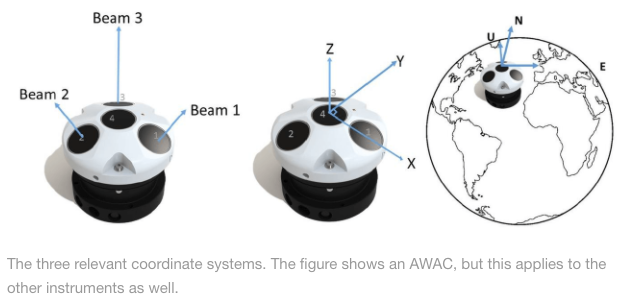

In [160]:
## Beam to ENU
subset_ad2cp = beam2enu(subset_ad2cp)

### Take a peak at ENU data

/tmp/ipykernel_26280/2605771011.py:23: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


ValueError: zero-size array to reduction operation minimum which has no identity

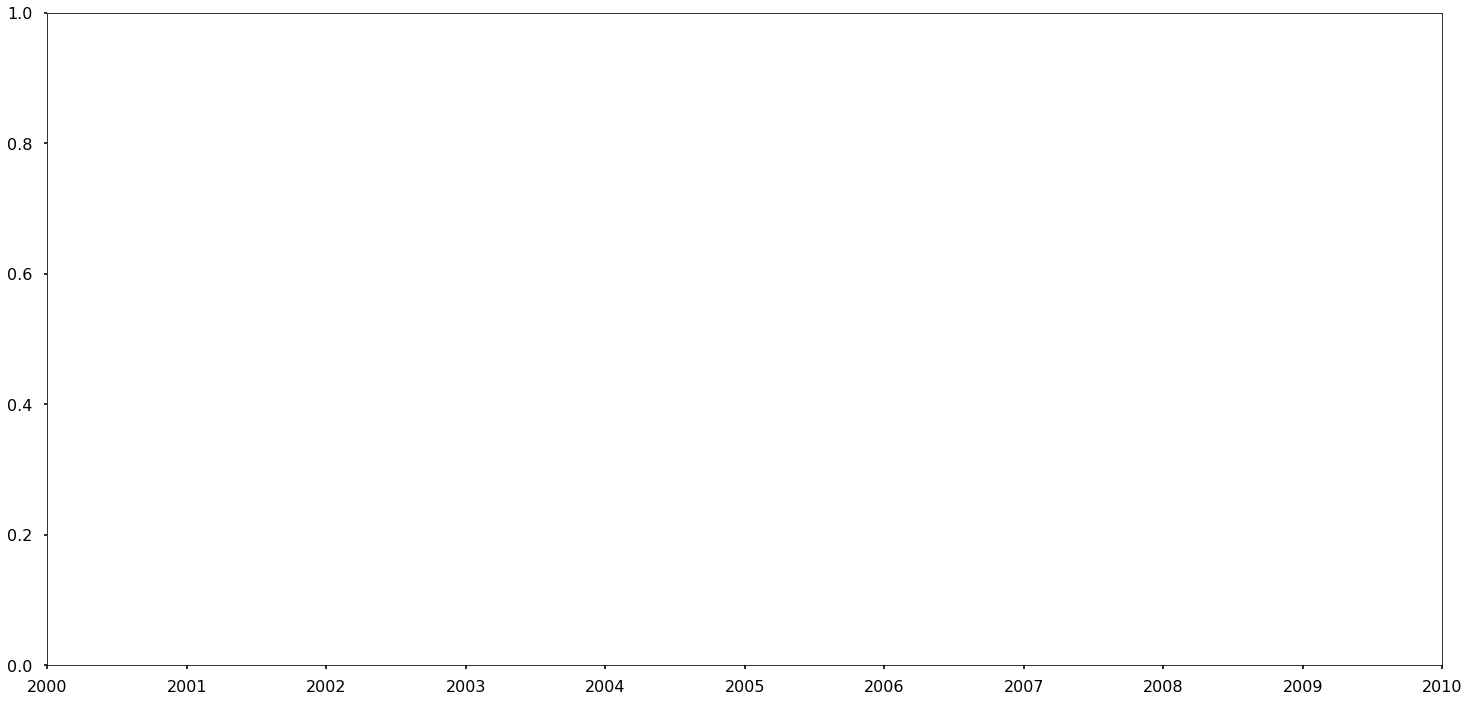

In [161]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins


# start_ind = 200
# end_ind   = 850

start_ind = 5000
end_ind   = 5500

# start_ind = 8060
# end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins


# start_ind = 200
# end_ind   = 850

# start_ind = 800
# end_ind   = 1500

start_ind = 8060
end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['UVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='E-W Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [ ]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 500
end_ind   = 850

# start_ind = 8060
# end_ind   = 8300

# start_ind = 14040
# end_ind   = 14300

# start_ind = 24800
# end_ind   = 25000


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [162]:
subset_ad2cp

<xarray.Dataset>
Dimensions:                    (time: 767, VelocityRange: 40, CorrelationRange: 40, AmplitudeRange: 40, Physicalbeam_dim: 4, AHRSRotationMatrix_dim: 9)
Coordinates:
  * time                       (time) datetime64[ns] 2021-07-06T20:41:15 ... ...
  * VelocityRange              (VelocityRange) float32 0.7 1.2 1.7 ... 19.7 20.2
  * CorrelationRange           (CorrelationRange) float32 0.7 1.2 ... 19.7 20.2
  * AmplitudeRange             (AmplitudeRange) float32 0.7 1.2 ... 19.7 20.2
Dimensions without coordinates: Physicalbeam_dim, AHRSRotationMatrix_dim
Data variables: (12/64)
    VelocityBeam1              (VelocityRange, time) float32 nan nan ... -0.1502
    VelocityBeam2              (VelocityRange, time) float32 nan nan ... 0.07409
    VelocityBeam3              (VelocityRange, time) float32 nan nan ... 0.1948
    VelocityBeam4              (VelocityRange, time) float32 nan nan ... 0.1069
    CorrelationBeam1           (CorrelationRange, time) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    CorrelationBeam2           (CorrelationRange, time) float32 dask.array<chunksize=(40, 1), meta=np.ndarray>
    ...                         ...
    InterpVelocityBeam2        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam3        (VelocityRange, time) float64 nan nan ... nan nan
    InterpVelocityBeam4        (VelocityRange, time) float64 0.09645 nan ... nan
    UVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
    VVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
    WVelocity                  (VelocityRange, time) float64 nan nan ... nan nan
Attributes: (12/350)
    exportRevision:                               4421
    File_ins_runTime:                             96653500.0
    File_ins_runTime_description:                 Length of time data was col...
    File_ins_name:                                AD2CPRaw
    File_ins_name_description:                    Name of instrument
    File_ins_typeName:                            
    ...                                           ...
    instrumentOffsetTime:                         0.0
    instrumentOffsetTime_description:             Offset from instrument time...
    timeZoneOffset:                               -18000
    timeZoneOffset_description:                   Offset of platform local ti...
    instrumentOffsetTimeMatlab:                   0.0
    instrumentOffsetTimeMatlab_description:       Offset from instrument time...

## Filter out really high velocities relative to glider and first bin below glider

/tmp/ipykernel_26280/3394160177.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])


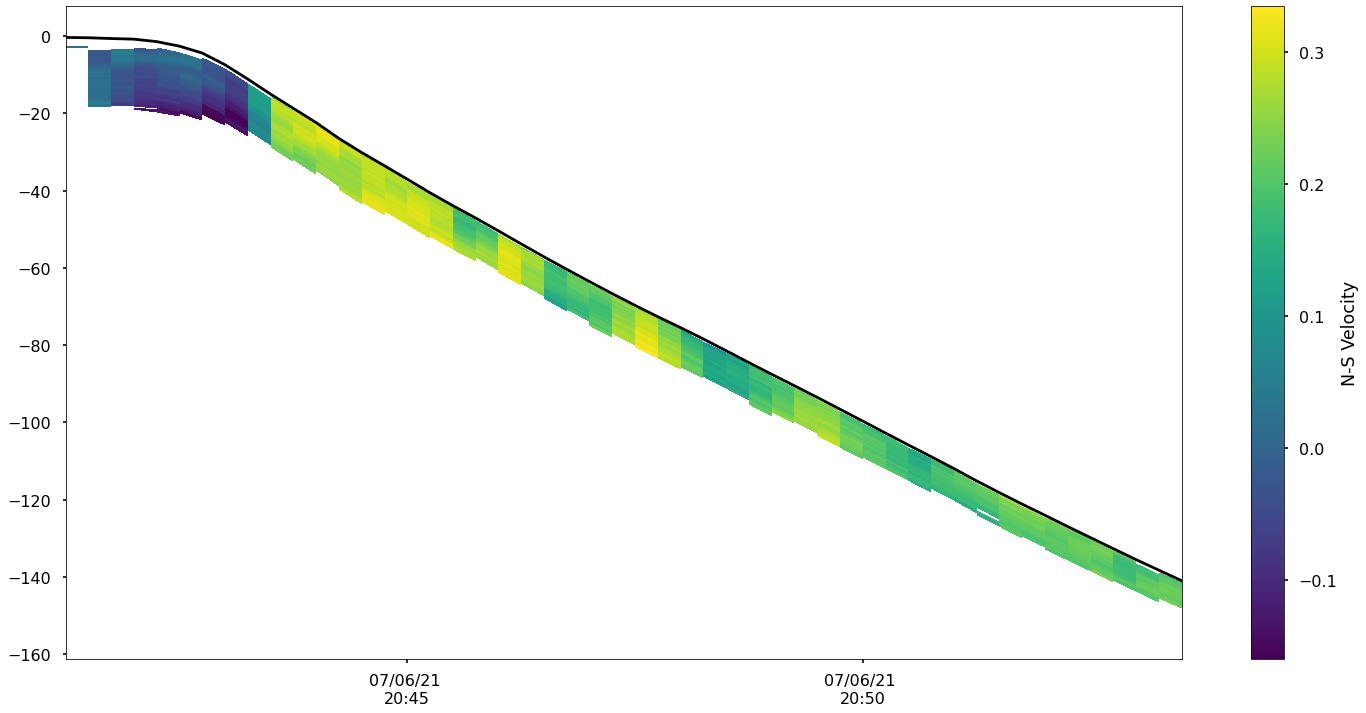

In [163]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 0
end_ind   = 50

fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind])
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

In [164]:
subset_ad2cp = qaqc_post_coord_transform(subset_ad2cp, high_velocity_threshold=0.75, surface_depth_to_filter = 5)

/tmp/ipykernel_26280/664111595.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')


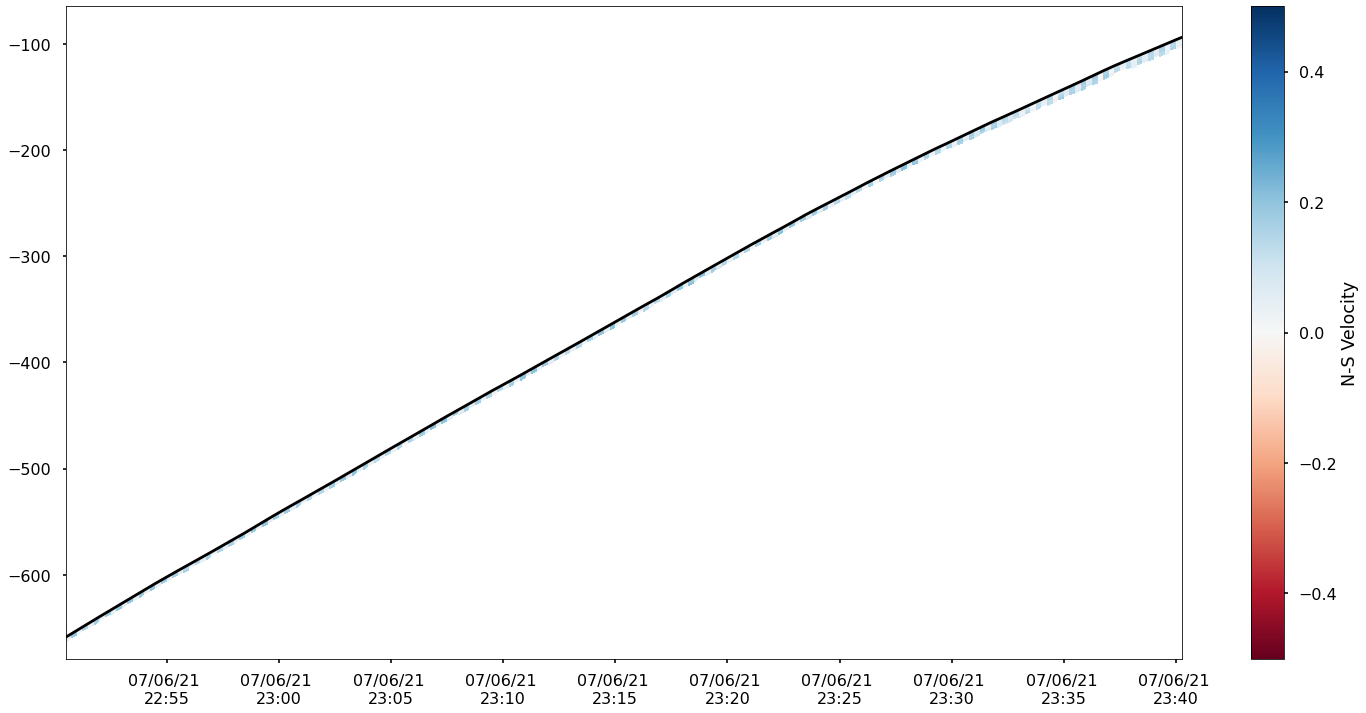

In [165]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

#start_ind = 350
#end_ind   = 550

start_ind = -250
end_ind   = -50


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

/tmp/ipykernel_26280/431571487.py:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')


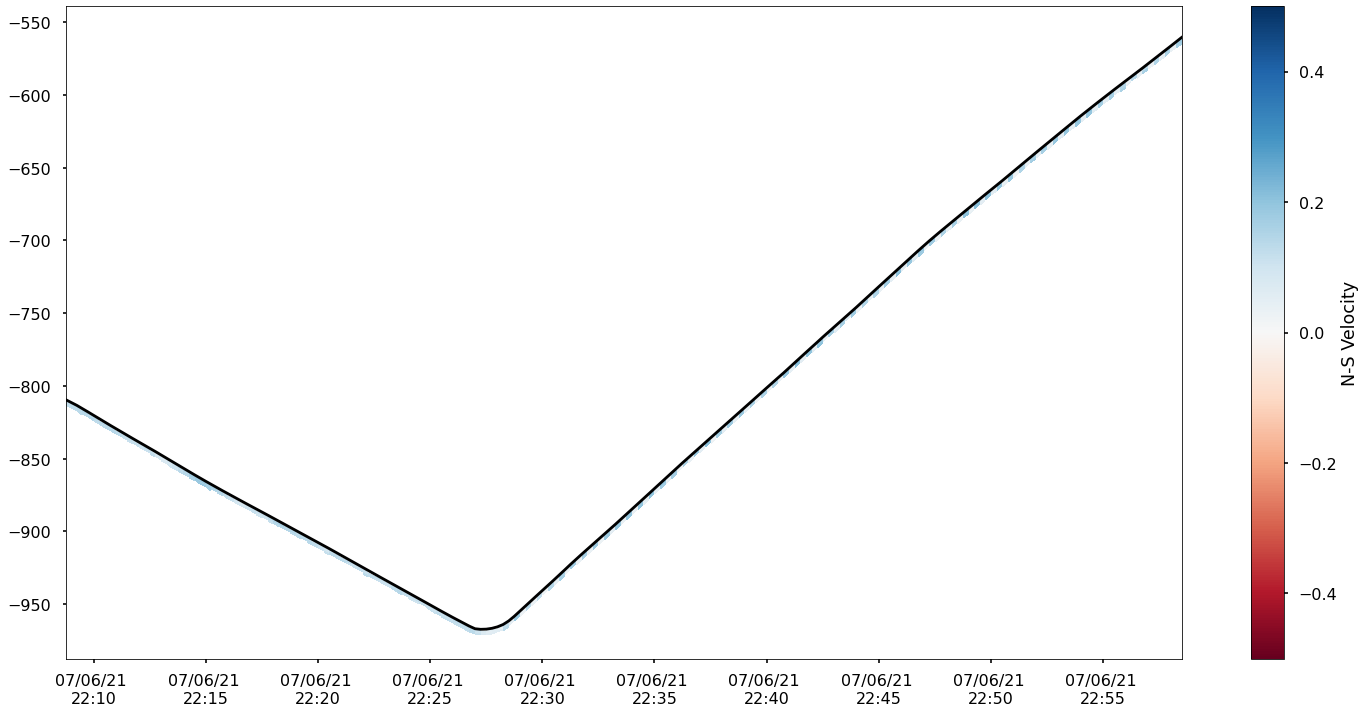

In [166]:
[x,y]=np.meshgrid(subset_ad2cp['time'],subset_ad2cp['VelocityRange'])
[bdepth,bbins]=np.meshgrid(subset_ad2cp['Pressure'],subset_ad2cp['VelocityRange'])

by=bdepth+bbins

start_ind = 350
end_ind   = 550

#start_ind = -250
#end_ind   = -50


fig = plt.figure(figsize=(25,12))
plt.pcolormesh(x[:,start_ind:end_ind],-by[:,start_ind:end_ind],subset_ad2cp['VVelocity'][:,start_ind:end_ind],vmin=-0.5,vmax=0.5,cmap='RdBu')
plt.plot(subset_ad2cp['time'][start_ind:end_ind],-subset_ad2cp['Pressure'][start_ind:end_ind],'k')
plt.colorbar(label='N-S Velocity')
plt.gca().xaxis.set_major_formatter(myFmtlong)

## Processing Step 9: Run the inversion!

In [167]:
start_time = time.time()

U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
dz=10
u_daverage=vx
v_daverage=vy
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values
wDAC = 5
wSmoothness = 1


## Feb-2021 jgradone@marine.rutgers.edu Initial
## Jul-2021 jgradone@marine.rutgers.edu Updates for constraints
## Jun-2022 jgradone@marine.rutgers.edu Corrected dimensions and indexing of G matrix
## Jun-2022 jgradone@marine.rutgers.edu Added curvature minimizing constraint and constraint weights

## Purpose: Take velocity measurements from glider mounted ADCP and compute
# shear profiles

## Outputs:
# O_ls is the ocean velocity profile
# G_ls is the glider velocity profile
# bin_new are the bin centers for the point in the profiles
# obs_per_bin is the number of good velocity observations per final profile bin

## Inputs:
# dz is desired vertical resolution, should not be smaller than bin length
# U is measured east-west velocities from ADCP
# V is measured north-south velocities from ADCP
# bins is the bin depths for the U and V measurements
# uv_daverage is depth averaged velocity (Set to 0 for real-time)
# depth is the depth of the glider measured by the ADCP
# wDAC is the weight of the DAC constraint (5 per Todd et al. 2017)
# wSmoothness is the weight of the curvature minimizing contraint


#########################################################################  
## These steps filter for NAN rows and columns so they are technically QAQC
## but I think the best place to put them is inthe inversion function because
## if there are NaNs still present in the data here, it will throw everything off
## These steps are HUGE for efficiency because it reduces the size of the G
## matrix as much as possible.

## This determines the rows (bins) where all the columns are NaN
nanind = np.where( (np.sum(np.isnan(U),axis=1)/U.shape[1]) == 1)[0]
if len(nanind) > 0:
    U = np.delete(U,nanind,axis=0)
    V = np.delete(V,nanind,axis=0)
    bins = np.delete(bins,nanind)

## Do the same thing with individual ensembles. Note: need to remove the corresponding
## ensemble pressure reading to ensure correction dimensions and values.
nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
if len(nanind) > 0:
    U = np.delete(U,nanind,axis=1)
    V = np.delete(V,nanind,axis=1)
    depth = np.delete(depth,nanind)
##########################################################################        


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth
# Calculate the maximum depth of glider which is different than maximum ADCP bin depth
ZmM = np.nanmax(depth)
##########################################################################        


##########################################################################        
# Set knowns from Equations 19 from Visbeck (2002) page 800
# Maximum number of observations (nd) is given by the number of velocity
# estimates per ping (nbin) times the number of profiles per cast (nt)
nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
nt   = U.shape[1]  # number of individual velocity profiles
nd   = nbin*nt      # G dimension (1) 

# Define the edges of the bins
bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

# Check that each bin has data in it
bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
bin_count[:] = np.NaN

for k in np.arange(len(bin_edges))[:-1]:
    # Create index of depth values that fall inside the bin edges
    ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
    bin_count[k] = len(bin_depth[ii])
    ii = []

# Create list of bin centers    
bin_new = [x+dz/2 for x in bin_edges[:-1]]
      
# Calculate which FINAL solution bin is deeper than the maximum depth of the glider
# This is done so that the depth averaged velocity constraint is only applied to bins shallower than this depth
depth_ind = len(np.where(bin_new>ZmM)[0])
# Chop off the top of profile if no data
ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
bin_new = bin_new[ind:]        # Removes all bins above first with data
z1 = bin_new[0]                # Depth of center of first bin with data
##########################################################################        


##########################################################################        
# Create and populate G
nz = len(bin_new)  # number of ocean velocities desired in output profile
nm = nt + nz       # G dimension (2), number of unknowns
# Let's build the corresponding coefficient matrix G 
G = scipy.sparse.lil_matrix((nd, nm), dtype=float)

# Indexing of the G matrix was taken from Todd et al. 2012
for ii in np.arange(0,nt):           # Number of ADCP ensembles per segment
    for jj in np.arange(0,nbin):     # Number of measured bins per ensemble 
                
        # Uctd part of matrix
        G[(nbin*(ii))+jj,ii] = -1
        # This will fill in the Uocean part of the matrix. It loops through
        # all Z members and places them in the proper location in the G matrix
        # Find the difference between all bin centers and the current Z value        
        dx = abs(bin_new-Z[jj,ii])
        # Find the minimum of these differences
        minx = np.nanmin(dx)
        # Finds bin_new index of the first match of Z and bin_new    
        idx = np.argmin(dx-minx)
        
        # Uocean part of matrix
        G[(nbin*(ii))+jj,(nt)+idx] = 1
        
        del dx, minx, idx
        
##########################################################################        
# Reshape U and V into the format of the d column vector (order='F')
# Based on how G is made, d needs to be ensembles stacked on one another vertically
d_u = U.flatten(order='F')
d_v = V.flatten(order='F')

##########################################################################
## This chunk of code containts the constraints for depth averaged currents
# Make sure the constraint is only applied to the final ocean velocity bins that the glider dives through
# Don't apply it to the first bin and don't apply it to the bins below the gliders dive depth
constraint = np.concatenate(([np.zeros(nt)], [0], [np.tile(dz,nz-(1+depth_ind))], [np.zeros(depth_ind)]), axis=None)

# Ensure the L^2 norm of the constraint equation is unity
constraint_norm = np.linalg.norm(constraint/ZmM)
C = 1/constraint_norm
constraint_normalized = (C/ZmM)*constraint ## This is now equal to 1 (unity)
# Build Gstar and add weight from todd 2017
## Some smarts would be to calculate signal to noise ratio first
Gstar = scipy.sparse.vstack((G,wDAC*constraint_normalized), dtype=float)


# Add the constraint for the depth averaged velocity from Todd et al. (2017)
du = np.concatenate(([d_u],[wDAC*C*u_daverage]), axis=None)
dv = np.concatenate(([d_v],[wDAC*C*v_daverage]), axis=None)
d = np.array(list(map(complex,du, dv)))


##########################################################################        
#### THIS removes all NaN elements of d AND Gstar so the inversion doesn't blow up with NaNs
ind2 = np.where(np.isnan(d)==True)[0]
d = np.delete(d,ind2)

def delete_rows_csr(mat, indices):
    """
    Remove the rows denoted by ``indices`` form the CSR sparse matrix ``mat``.
    """
    if not isinstance(mat, scipy.sparse.csr_matrix):
        raise ValueError("works only for CSR format -- use .tocsr() first")
    indices = list(indices)
    mask = np.ones(mat.shape[0], dtype=bool)
    mask[indices] = False
    return mat[mask]

Gstar = delete_rows_csr(Gstar.tocsr().copy(),ind2)

#########################################################################        
# Test adding depth for tracking bin location
# d is ensembles stacked on one another vertically so same for Z (order='F')
Z_filt = Z.flatten(order='F')
Z_filt = np.delete(Z_filt,ind2)
Z_filt = np.concatenate(([Z_filt],[0]), axis=None)

##########################################################################        
## Calculation the number of observations per bin
obs_per_bin = np.empty(len(bin_new))
obs_per_bin[:] = np.NaN

for x in np.arange(0,nz):
    rows_where_nt_not_equal_zero = np.where(Gstar.tocsr()[0:Z_filt.shape[0],nt+x].toarray() > 0 )[0]
    obs_per_bin[x] = len(rows_where_nt_not_equal_zero)

## If there is no data in the last bin, drop that from the G matrix, bin_new, and obs_per_bin
if obs_per_bin[-1] == 0:
    Gstar.tocsr()[:,:-1]
    bin_new = bin_new[:-1]
    obs_per_bin = obs_per_bin[:-1]
    ## Update nz and nt
    nz = len(bin_new)
    nt = Gstar.shape[1]-nz
    
##########################################################################        
## Run the Least-Squares Inversion pre smoothing
x = lsqr(Gstar, d)[0]

O_ls = x[nt:]
G_ls = x[0:nt]

##########################################################################        
## Smoothness constraint
## Only do this is the smoothness constraint is set
if wSmoothness > 0:
    ## Add a vector of zerosm the length of nz, twice to the bottom of the data column vector
    d = np.concatenate(([d],[np.zeros(nz)],[np.zeros(nz)]), axis=None)
    ## Constraint on smoothing Uocean side of matrix
    smoothing_matrix_Uocean = scipy.sparse.diags([[-1],[2],[-1]], [0,1,2], shape=(nz,nz))
    smoothing_matrix1 = scipy.sparse.hstack((np.zeros((nz,nt)),smoothing_matrix_Uocean), dtype=float)
    ## Constraint on smoothing Uglider side of matrix
    smoothing_matrix_Uglider = scipy.sparse.diags([[-1],[2],[-1]], [0,1,2], shape=(nz,nt))
    smoothing_matrix2 = scipy.sparse.hstack((smoothing_matrix_Uglider,np.zeros((nz,nz))), dtype=float)
    Gstar = scipy.sparse.vstack((Gstar,wSmoothness*smoothing_matrix1,wSmoothness*smoothing_matrix2), dtype=float)

    
##########################################################################        
## Run the Least-Squares Inversion!
x = lsqr(Gstar, d)[0]

O_ls_smooth = x[nt:]
G_ls_smooth = x[0:nt] 
########################################################################## 
       
#return(O_ls, G_ls, bin_new, obs_per_bin)


print("My program took", time.time() - start_time, "to run")

My program took 1.270015001296997 to run


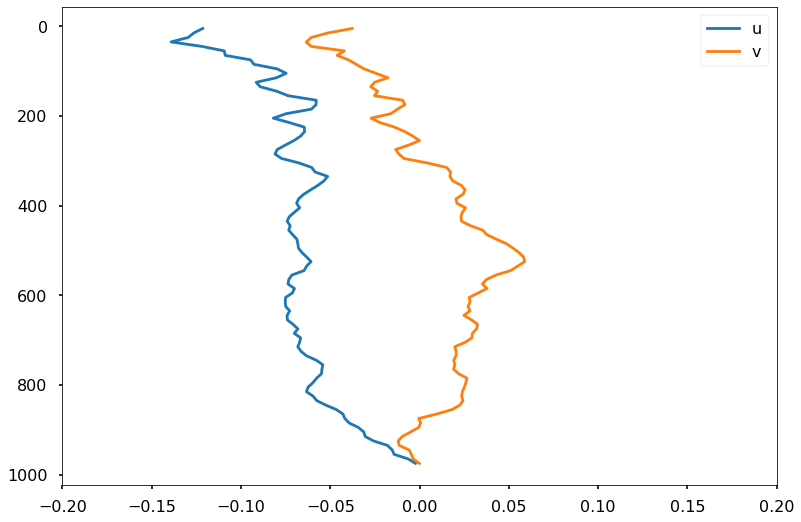

In [168]:
plt.plot(np.real(O_ls_smooth),bin_new,label='u')
plt.plot(np.imag(O_ls_smooth),bin_new,label='v')
plt.gca().invert_yaxis()
plt.xlim(-0.2,0.2)
plt.legend()

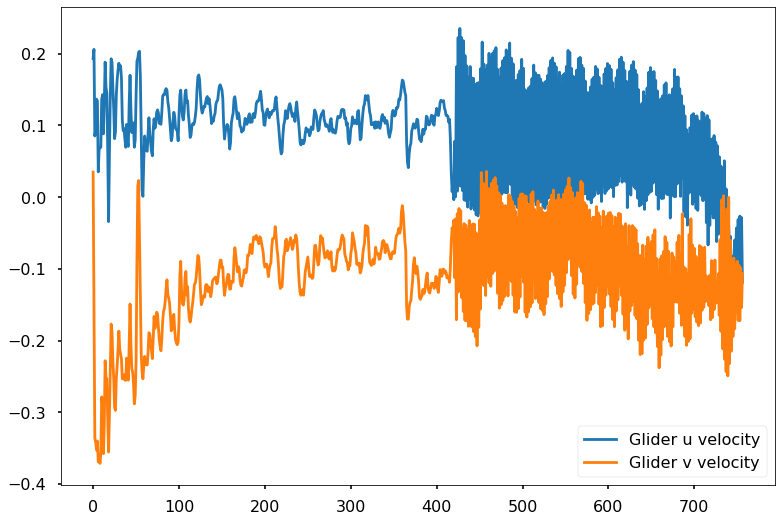

In [169]:
plt.plot(np.real(G_ls),label='Glider u velocity')
plt.plot(np.imag(G_ls),label='Glider v velocity')
plt.legend()

In [170]:
print('vx:',vx)
print('new caculated EW DAC:',np.nanmean(np.real(O_ls)))
print('vy:',vy)
print('new caculated NS DAC:',np.nanmean(np.imag(O_ls)))

vx: -0.0665451
new caculated EW DAC: -0.06723285785339879
vy: 0.00892125
new caculated NS DAC: 0.00846643798999212


In [ ]:
plt.plot(np.sum((np.isnan(U)==False),axis=0))

In [ ]:
np.nanmedian(np.sum((np.isnan(U)==False),axis=0))

In [ ]:
bins

In [171]:
def calc_ensemble_shear(vel, cell_depths):
    dz = cell_depths[1]-cell_depths[0]
    
    ensemble_shear = np.empty((vel.shape[0],vel.shape[1]))
    
    ## Loop through each ensemble
    for y in np.arange(0,vel.shape[1]):
        ensemble_shear[:,y] = np.gradient(vel[:,y], dz)
    return(ensemble_shear)



In [172]:
testu = calc_ensemble_shear(U, bins)


In [ ]:
testu.shape

In [ ]:
Z

# Shear Method

In [173]:
def edgetocentre(x_in):
    x_out = np.array(x_in)
    return np.nanmean([x_out[1:], x_out[:-1]], axis=0)

def centretoedge(x_in):
    x_out = np.array(np.empty(len(x_in) + 1))
    x_out[:-1] = x_in - (x_in[1] - x_in[0]) / 2
    x_out[-1] = x_in[-1] + (x_in[1] - x_in[0]) / 2
    return x_out


def bin_attr(shear_v, shear_z, bin_size, Hmax):
    """
    Function takes scattered shear velocities in three dimensions (can be beam, xyz or enu) with the depths they were
    taken at. Can specify a bin size in which they will be averaged and a reference velocity (3D) for the profile.
    :param shear_v: 3 column array of velociy shears
    :param shear_z: 1 column array of the z location of shear. z positive upward from sea surface
    :param bin_size: Size of bin to average shear data in
    :param Hmax: Maximum depth of the profile (need to be negative)
    :return: shear velocity profile in three columns, bin centers for shear profile, number of samples in each bin
    
    """
    bin_edges = np.arange(Hmax, 0 + bin_size, bin_size)
    bin_centers = edgetocentre(bin_edges)
    no_in_bin = np.empty((len(bin_centers)))
    shear_av = np.empty((len(bin_centers), 3))
    shear_av[:] = np.nan
    shear_std = np.empty((len(bin_centers), 3))
    shear_std[:] = np.nan
    for depth_bin in np.arange(len(bin_centers)):
        vel_in_bin = shear_v[
            np.logical_and(
                shear_z > bin_edges[depth_bin], shear_z < bin_edges[depth_bin + 1]
            ),
            :,
        ]
        no_in_bin[depth_bin] = np.size(vel_in_bin, 0)
        if vel_in_bin.size > 0:
            shear_av[depth_bin, :] = np.nanmedian(vel_in_bin, 0)
            shear_std[depth_bin, :] = np.nanstd(vel_in_bin, 0)
        
        idbad = np.where(no_in_bin == 0)
        shear_av[idbad,:] = np.nan
        shear_std[idbad,:] = np.nan
    
    return shear_av, shear_std, bin_centers, no_in_bin


def shear_to_vel(shear_av, bin_centers, ref_vel):
    """
    Takes vertically binned 3 column shear and a reference velocity. Performs a simple integration of shear
    and references velocity profile to ref_vel
    :param shear_av:
    :param bin_centers:
    :param ref_vel: Reference velocity that pfofile should average to
    :return: Velocity of profile, bin centers
    """
    if ref_vel is None:
        ref_vel = [0, 0, 0]
    nans = np.isnan(shear_av)
    shear_av[nans] = 0.0
    vel = np.empty((np.shape(shear_av)))
    vel[:] = 0
    dz = bin_centers[1] - bin_centers[0]
    
    for depth_bin in np.arange(1, len(bin_centers)):
        vel[depth_bin, :] = vel[depth_bin - 1, :] - shear_av[depth_bin, :] * dz
    vel[nans] = np.nan
    vel_referenced = vel - np.tile(np.nanmean(vel, 0) - ref_vel, (len(bin_centers), 1))
    
    return vel, vel_referenced, bin_centers


# def calc_ensemble_shear(vel, cell_depths):
#     dz = cell_depths[1]-cell_depths[0]
    
#     ensemble_shear = np.empty((vel.shape[0],vel.shape[1]))
    
#     ## Loop through each ensemble
#     for y in np.arange(0,vel.shape[1]):
#         ensemble_shear[:,y] = np.gradient(vel[:,y])/dz
#     return(ensemble_shear)

def calc_ensemble_shear(vel, cell_depths):
    bin_size = cell_depths[1]-cell_depths[0]
    ensemble_shear = np.empty((vel.shape[0]-1,vel.shape[1]))

    ## Loop through each ensemble
    for y in np.arange(0,vel.shape[1]):
        ## Loop through bin
        for x in np.arange(0,vel.shape[0]-1):
            ensemble_shear[x,y] = (vel[x+1,y]-vel[x,y])/bin_size
    return(ensemble_shear)



def shear_method(U,V,W,vx,vy,bins,depth,dz):
    ########################################################################  
    # These steps filter for NAN rows and columns so they are technically QAQC
    # but I think the best place to put them is inthe inversion function because
    # if there are NaNs still present in the data here, it will throw everything off
    # These steps are HUGE for efficiency because it reduces the size of the G
    # matrix as much as possible.

    ## This determines the rows (bins) where all the columns are NaN
#     nanind = np.where( (np.sum(np.isnan(U),axis=1)/U.shape[1]) == 1)[0]
#     if len(nanind) > 0:
#         U = np.delete(U,nanind,axis=0)
#         V = np.delete(V,nanind,axis=0)
#         W = np.delete(W,nanind,axis=0)
#         bins = np.delete(bins,nanind)

#     ## Do the same thing with individual ensembles. Note: need to remove the corresponding
#     ## ensemble pressure reading to ensure correction dimensions and values.
#     nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
#     if len(nanind) > 0:
#         U = np.delete(U,nanind,axis=1)
#         V = np.delete(V,nanind,axis=1)
#         W = np.delete(W,nanind,axis=1)
#         depth = np.delete(depth,nanind)
    ##########################################################################        


    ##########################################################################        
    # Take difference between bin lengths for bin size [m]
    bin_size = np.diff(bins)[0]
    bin_num = len(bins)
    # This creates a grid of the ACTUAL depths of the ADCP bins by adding the
    # depths of the ADCP bins to the actual depth of the instrument


    [bdepth,bbins]=np.meshgrid(depth,bins)
    bin_depth = bdepth+bbins  

    Z = bin_depth
    # Calculate the maximum depth of glider which is different than maximum ADCP bin depth
    ZmM = np.nanmax(depth)

    ## Calculate shear per ensemble
    ensemble_shear_U = calc_ensemble_shear(U,bins)
    ensemble_shear_V = calc_ensemble_shear(V,bins)
    ensemble_shear_W = calc_ensemble_shear(W,bins)

    ## Create velocity dataframes for shear
    flatu = ensemble_shear_U.flatten(order='F')
    flatv = ensemble_shear_V.flatten(order='F')
    flatw = ensemble_shear_W.flatten(order='F')
    flatz = -Z.flatten(order='F')
    flat_df = np.column_stack((flatu,flatv,flatw,flatz))
    flat_df = flat_df[flat_df[:, 3].argsort()[::-1]]

    ## Shear binning
    shear_binned, shear_binned_std, shear_cell_center, vels_in_bin = bin_attr(shear_v= flat_df[:,0:3], shear_z=flat_df[:,3], bin_size=dz, Hmax=np.nanmin(flat_df[:,3]))
    ## Shear to absolute
    vel, vel_referenced, bin_centers = shear_to_vel(shear_binned, shear_cell_center, ref_vel=[vx,vy,0])
    
    ## First define uncertainty of a single ping according to the ADCP configuration
    std_ping = 0.03     #[m/s] (in average mode)
    vel_referenced_std = np.sqrt(std_ping**2 + shear_binned_std**2)
    
    return(vel, vel_referenced, bin_centers, shear_binned, shear_binned_std, shear_cell_center, vels_in_bin)


In [185]:
U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
vx=vx
vy=vy
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values
dz=2


#def shear_method(U,V,,vx,vy,bins,depth,dz):
########################################################################  
# These steps filter for NAN rows and columns so they are technically QAQC
# but I think the best place to put them is inthe inversion function because
# if there are NaNs still present in the data here, it will throw everything off
# These steps are HUGE for efficiency because it reduces the size of the G
# matrix as much as possible.

# This determines the rows (bins) where all the columns are NaN
nanind = np.where( (np.sum(np.isnan(U),axis=1)/U.shape[1]) == 1)[0]
if len(nanind) > 0:
    U = np.delete(U,nanind,axis=0)
    V = np.delete(V,nanind,axis=0)
    bins = np.delete(bins,nanind)

## Do the same thing with individual ensembles. Note: need to remove the corresponding
## ensemble pressure reading to ensure correction dimensions and values.
nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
if len(nanind) > 0:
    U = np.delete(U,nanind,axis=1)
    V = np.delete(V,nanind,axis=1)
    depth = np.delete(depth,nanind)
##########################################################################        


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins
Z = bin_depth
## Create bin edges
bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz)
# Create list of bin centers    
bin_centers = np.array([x+dz/2 for x in bin_edges[:-1]])
##########################################################################        


##########################################################################        
## Calculate shear per ensemble
ensemble_shear_U = calc_ensemble_shear(U,bins)
ensemble_shear_V = calc_ensemble_shear(V,bins)
## Create velocity dataframes for shear
flatu = ensemble_shear_U.flatten(order='F')
flatv = ensemble_shear_V.flatten(order='F')
flatz = Z[:-1,:].flatten(order='F')
##########################################################################        


##########################################################################        
## Preallocate
shearu_binned_median = np.empty(len(bin_centers))
shearv_binned_median = np.empty(len(bin_centers))
shearu_binned_std    = np.empty(len(bin_centers))
shearv_binned_std    = np.empty(len(bin_centers))
shearu_obs_per_bin   = np.empty(len(bin_centers))
shearv_obs_per_bin   = np.empty(len(bin_centers))

## Shear binning
for x in np.arange(0,len(bin_edges)-1):
    depth_ind = np.where((flatz >= bin_edges[x]) & (flatz >= bin_edges[x+1]))
    
    shearu_binned_median[x] = np.nanmean(flatu[depth_ind])
    shearv_binned_median[x] = np.nanmean(flatv[depth_ind])
    shearu_binned_std[x]    = np.nanstd(flatu[depth_ind])
    shearv_binned_std[x]    = np.nanstd(flatv[depth_ind])
    shearu_obs_per_bin[x]   = np.sum(np.isnan(flatu[depth_ind])==False)
    shearv_obs_per_bin[x]   = np.sum(np.isnan(flatv[depth_ind])==False)

## Check if there are any bins with 0 observations and if so toss that data
if (shearu_obs_per_bin == 0).any():
    ## Get only the non-zero observation bins
    ind = np.where(shearu_obs_per_bin != 0)[0]
    shearu_binned_median = shearu_binned_median[ind]
    shearv_binned_median = shearv_binned_median[ind]
    shearu_binned_std    = shearu_binned_std[ind]
    shearv_binned_std    = shearv_binned_std[ind]
    shearu_obs_per_bin   = shearu_obs_per_bin[ind]
    shearv_obs_per_bin   = shearv_obs_per_bin[ind]
    bin_centers          = bin_centers[ind]

# # Calculate relative profile but flipping, integrating from bottom, then flipping back
#rel_V = np.flip(integrate.cumtrapz(np.flip(shearu_binned_median), dx=dz))
#rel_U = np.flip(integrate.cumtrapz(np.flip(shearv_binned_median), dx=dz))
# ## Bin centers loses it's last bin during the integration
#bin_centers = bin_centers[:-1]
# ## Now add depth averaged current
# vref = vy - np.nanmean(rel_V)
# uref = vx - np.nanmean(rel_U)
# ## And here comes the references velocity
# V_shear_method = rel_V - vref
# U_shear_method = rel_U - uref


vel_u = np.zeros(len(bin_centers))
vel_v = np.zeros(len(bin_centers))


for x in np.arange(1, len(bin_centers)):
    vel_u[x] = vel_u[x - 1] - np.flip(shearu_binned_median)[x] * dz
    vel_v[x] = vel_v[x - 1] - np.flip(shearv_binned_median)[x] * dz

vel_v = np.flip(vel_v)
vel_u = np.flip(vel_u)


vel_referenced_u = vel_u - np.tile(np.nanmean(vel_u) - vx, len(bin_centers))
vel_referenced_v = vel_v - np.tile(np.nanmean(vel_v) - vy, len(bin_centers))


# ## First define uncertainty of a single ping according to the ADCP configuration
std_ping = 0.03     #[m/s] (in average mode)
vel_referenced_std_u = np.sqrt(std_ping**2 + shearu_binned_std**2)
vel_referenced_std_v = np.sqrt(std_ping**2 + shearv_binned_std**2)



/tmp/ipykernel_26280/2021806554.py:75: RuntimeWarning: Mean of empty slice
  shearu_binned_median[x] = np.nanmean(flatu[depth_ind])
/tmp/ipykernel_26280/2021806554.py:76: RuntimeWarning: Mean of empty slice
  shearv_binned_median[x] = np.nanmean(flatv[depth_ind])
/projects/dmcs_1/sw/packages/xroms/py38/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [186]:
# vel = np.empty(len(shearu_binned_median))
# vel[:] = 0
# ref_vel=vx

# for x in np.arange(1, len(bin_centers)):
#     vel[x] = vel[x - 1] - shearu_binned_median[x] * dz
# vel_referenced = vel - np.tile(np.nanmean(vel) - ref_vel, len(bin_centers))


## Mathieu shear method

In [187]:
# vel, vel_referenced, bin_centers, shear_binned, shear_binned_std, shear_cell_center, vels_in_bin = shear_method(U=subset_ad2cp.UVelocity.values, V=subset_ad2cp.VVelocity.values, W=subset_ad2cp.WVelocity.values, vx=vx, vy=vy, bins = subset_ad2cp['VelocityRange'].values, depth = subset_ad2cp['Pressure'].values, dz=10)


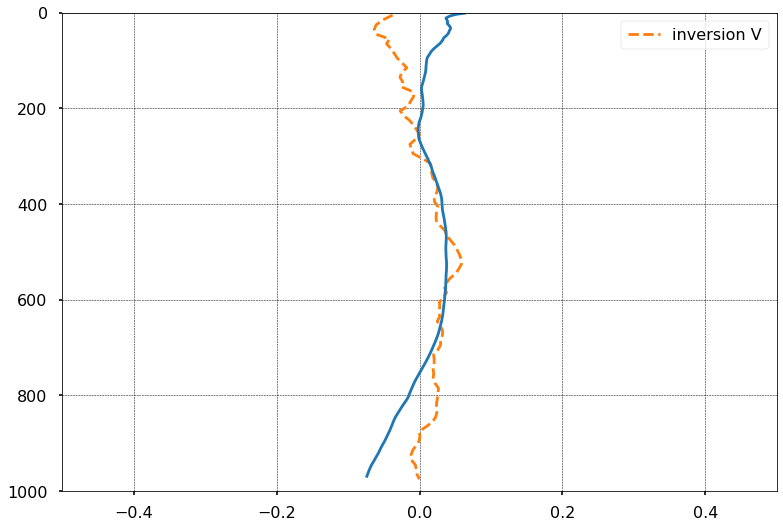

In [188]:
plt.plot(np.imag(O_ls_smooth),bin_new,label='inversion V',color='tab:orange',linestyle='--')
plt.plot(vel_referenced_v,bin_centers)

# plt.plot(vel_referenced[:,1],-bin_centers,label='shear V',color='tab:orange')
# plt.fill_betweenx(-bin_centers,
#                   vel_referenced[:,1]-vel_referenced_std[:,1],
#                   vel_referenced[:,1]+vel_referenced_std[:,1],
#                   facecolor='tab:orange',alpha=0.15)
plt.ylim(1000,0)
plt.xlim(-0.5,0.5)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5)
plt.legend()

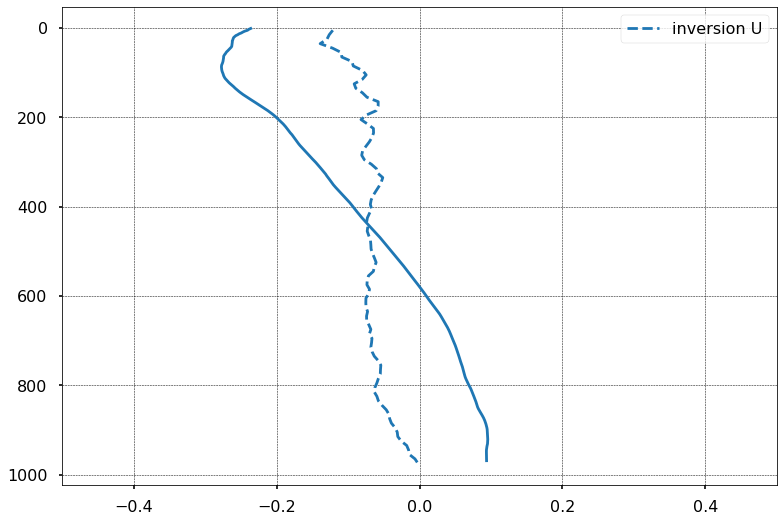

In [189]:
plt.plot(np.real(O_ls_smooth),bin_new,label='inversion U',color='tab:blue',linestyle='--')

plt.plot(vel_referenced_u,bin_centers)

#plt.plot(vel_referenced[:,0],-bin_centers,label='shear U',color='tab:blue')
# plt.fill_betweenx(-bin_centers,
#                   vel_referenced[:,0]-vel_referenced_std[:,0],
#                   vel_referenced[:,0]+vel_referenced_std[:,0],
#                   facecolor='tab:blue',alpha=0.15)
#plt.ylim(1000,0)
plt.gca().invert_yaxis()
plt.xlim(-0.5,0.5)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5)
plt.legend()

## Quick shot at shear method

In [ ]:
def shear_method(U, V, dz, vx, vy, bins, depth):

    ##########################################################################        
    ## This determines the rows (bins) where all the columns are NaN
    nanind = np.where( (np.sum(np.isnan(U),axis=1)/U.shape[1]) == 1)[0]
    if len(nanind) > 0:
        U = np.delete(U,nanind,axis=0)
        V = np.delete(V,nanind,axis=0)
        bins = np.delete(bins,nanind)

    ## Do the same thing with individual ensembles. Note: need to remove the corresponding
    ## ensemble pressure reading to ensure correction dimensions and values.
    nanind = np.where((np.sum(np.isnan(U),axis=0)/U.shape[0]) == 1)[0]
    if len(nanind) > 0:
        U = np.delete(U,nanind,axis=1)
        V = np.delete(V,nanind,axis=1)
        depth = np.delete(depth,nanind)

    ##########################################################################        
    # Take difference between bin lengths for bin size [m]
    bin_size = np.diff(bins)[0]
    bin_num = len(bins)
    # This creates a grid of the ACTUAL depths of the ADCP bins by adding the
    # depths of the ADCP bins to the actual depth of the instrument
    [bdepth,bbins]=np.meshgrid(depth,bins)
    bin_depth = bdepth+bbins  
    Z = bin_depth
    # Calculate the maximum depth of glider which is different than maximum ADCP bin depth
    ZmM = np.nanmax(depth)
    ##########################################################################        


    ##########################################################################        
    # Set knowns from Equations 19 from Visbeck (2002) page 800
    # Maximum number of observations (nd) is given by the number of velocity
    # estimates per ping (nbin) times the number of profiles per cast (nt)
    nbin = U.shape[0]  # number of programmed ADCP bins per individual profile
    nt   = U.shape[1]  # number of individual velocity profiles
    nd   = nbin*nt      # G dimension (1) 

    # Define the edges of the bins
    bin_edges = np.arange(0,math.floor(np.max(bin_depth)),dz).tolist()

    # Check that each bin has data in it
    bin_count = np.empty(len(bin_edges)-1) # Preallocate memory
    bin_count[:] = np.NaN

    for k in np.arange(len(bin_edges))[:-1]:
        # Create index of depth values that fall inside the bin edges
        ii = np.where((bin_depth > bin_edges[k]) & (bin_depth < bin_edges[k+1]))
        bin_count[k] = len(bin_depth[ii])
        ii = []

    # Create list of bin centers    
    bin_new_shear = [x+dz/2 for x in bin_edges[:-1]]
    ##########################################################################        


    ##########################################################################        
    # Calculate which FINAL solution bin is deeper than the maximum depth of the glider
    # This is done so that the depth averaged velocity constraint is only applied to bins shallower than this depth
    depth_ind = len(np.where(bin_new_shear>ZmM)[0])
    # Chop off the top of profile if no data
    ind = np.argmax(bin_count > 0) # Stops at first index greater than 0
    bin_new_shear = bin_new_shear[ind:]        # Removes all bins above first with data
    z1 = bin_new_shear[0]                # Depth of center of first bin with data
    ##########################################################################        


    ##########################################################################        
    ## Preallocate for much much bigger than it really needs to be
    U_mat = np.empty((len(bin_new_shear),nt*nbin))
    U_mat[:] = np.NaN
    V_mat = np.empty((len(bin_new_shear),nt*nbin))
    V_mat[:] = np.NaN

    ## Bin the velocity data into final solution bins
    for ii in np.arange(0,nt):           # Number of ADCP ensembles per segment
        for jj in np.arange(0,nbin):     # Number of measured bins per ensemble 

            # Find the difference between all bin centers and the current Z value        
            dx = abs(bin_new_shear-Z[jj,ii])
            # Find the minimum of these differences
            minx = np.nanmin(dx)
            # Finds bin_new index of the first match of Z and bin_new    
            idx = np.argmin(dx-minx)
            ## Pull out this velocity
            U_mat[idx,(nbin*(ii))+jj] = U[jj,ii]
            V_mat[idx,(nbin*(ii))+jj] = V[jj,ii]


    ## Median velocity value per depth bin
    U_prof = np.nanmedian(U_mat,axis=1)
    V_prof = np.nanmedian(V_mat,axis=1)
    ## Standard deviation of velocity per depth bin
    U_prof_std = np.nanstd(U_mat,axis=1)
    V_prof_std = np.nanstd(V_mat,axis=1)
    ## Calculate observations per bin
    obs_per_bin = np.sum(~np.isnan(U_mat),axis=1)

    # ## Chop off the bottom of the profile is there are nans
    # nanind = np.isnan(U_prof).any()
    # if nanind == True:
    #     nanind = np.where(np.isnan(U_prof)==True)[0]
    #     U_prof = U_prof[0:nanind[0]]
    #     V_prof = V_prof[0:nanind[0]]
    #     U_prof_std = U_prof_std[0:nanind[0]]
    #     V_prof_std = V_prof_std[0:nanind[0]]
    #     bin_new_shear = bin_new_shear[0:nanind[0]]
    #     obs_per_bin = obs_per_bin[0:nanind[0]]

    def fill_nan(A):    
        ok = ~np.isnan(A)
        xp = ok.ravel().nonzero()[0]
        fp = A[~np.isnan(A)]
        x  = np.isnan(A).ravel().nonzero()[0]

        A[np.isnan(A)] = np.interp(x, xp, fp)
        return A

    ## Interpolate NaNs if needed
    U_prof = fill_nan(U_prof)
    V_prof = fill_nan(V_prof)


    ## Calculate shear profiles
    dU_dZ = np.gradient(U_prof,dz)
    dV_dZ = np.gradient(V_prof,dz)

    # Calculate relative profile but flipping, integrating from bottom, then flipping back
    rel_V = np.flip(integrate.cumtrapz(np.flip(dV_dZ), dx=dz))
    rel_U = np.flip(integrate.cumtrapz(np.flip(dU_dZ), dx=dz))


    ## Now add depth averaged current
    vref = vy - np.nanmean(rel_V)
    V_shear_method = rel_V + vref
    uref = vx - np.nanmean(rel_U)
    U_shear_method = rel_U + uref
    

    return U_shear_method, V_shear_method, U_prof_std[0:-1], V_prof_std[0:-1], bin_new_shear[0:-1], obs_per_bin[0:-1]

In [ ]:

U_shear_method, V_shear_method, U_prof_std, V_prof_std, bin_new_shear, obs_per_bin = shear_method(U=subset_ad2cp.UVelocity.values, V=subset_ad2cp.VVelocity.values, dz=10, vx=vx, vy=vy, bins = subset_ad2cp['VelocityRange'].values, depth = subset_ad2cp['Pressure'].values)

std_ping = 0.03


## Uncertainty propagation
u_shear_std = np.sqrt(std_ping**2 + U_prof_std**2)
v_shear_std = np.sqrt(std_ping**2 + V_prof_std**2)



In [ ]:
print('vx:',vx)
print('Shear Method Caculated EW DAC:',np.nanmean(U_shear_method))
print('vy:',vy)
print('Shear Method Caculated NS DAC:',np.nanmean(V_shear_method))

In [ ]:
plt.fill_betweenx(bin_new_shear, U_shear_method-u_shear_std, U_shear_method+u_shear_std,alpha=0.2,color='tab:blue')
plt.plot(np.real(O_ls_smooth),bin_new,color='tab:blue',linestyle='--',label='inversion method')
plt.plot(U_shear_method,bin_new_shear, label='shear method',color='tab:blue')
plt.ylim(1000,0)
plt.xlim(-0.5,0.5)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5)
plt.legend()


In [ ]:
plt.fill_betweenx(bin_new_shear, V_shear_method-v_shear_std, V_shear_method+v_shear_std,alpha=0.2,color='tab:orange')
plt.plot(V_shear_method,bin_new_shear, label='shear method',color='tab:orange')
plt.plot(np.imag(O_ls_smooth),bin_new,color='tab:orange',linestyle='--',label='inversion method')
plt.ylim(1000,0)
plt.xlim(-0.5,0.5)
plt.grid(color = 'k', linestyle = '--', linewidth = 0.5)
plt.legend()


# Loess Filter Testing

In [ ]:
U=subset_ad2cp.UVelocity.values
V=subset_ad2cp.VVelocity.values
bins = subset_ad2cp['VelocityRange'].values
depth = subset_ad2cp['Pressure'].values


##########################################################################        
# Take difference between bin lengths for bin size [m]
bin_size = np.diff(bins)[0]
bin_num = len(bins)
# This creates a grid of the ACTUAL depths of the ADCP bins by adding the
# depths of the ADCP bins to the actual depth of the instrument
[bdepth,bbins]=np.meshgrid(depth,bins)
bin_depth = bdepth+bbins  
Z = bin_depth

##########################################################################        
# Reshape U and V and Z
flatu = U.flatten(order='F')
flatv = V.flatten(order='F')
flatz = Z.flatten(order='F')
# Make a dataframe for easy sorting and filtering
flatd = {'depth': flatz, 'u': flatu, 'v': flatv}
flat_df = pd.DataFrame(data=flatd)
flat_df = flat_df.sort_values(by=['depth'])
flat_df = flat_df.dropna(subset=['u', 'v'], how='all')

##########################################################################        
# Define the edges of the final velocity profile bins
#bin_edges = np.arange(0,math.ceil(np.max(flat_df.depth)),dz).tolist()
# Create list of bin centers    
#bin_new = [x+dz/2 for x in bin_edges[:-1]]
##########################################################################        


plt.plot(flat_df.v,flat_df.depth,'.',label='NS Velocity')
plt.plot(np.imag(O_ls_smooth),bin_new,color='tab:orange',linestyle='--',label='inversion method')
plt.gca().invert_yaxis()
plt.legend()

In [ ]:
# plt.plot(flat_df.u,flat_df.depth,'.',label='EW Velocity')

# plt.plot(np.real(O_ls_smooth),bin_new,color='tab:orange',linestyle='--',label='inversion method')

# plt.gca().invert_yaxis()
# plt.legend()

# Testing and Data Exploration

### Checking on pitch vattery-dependent magnetic heading correction

In [ ]:
# # x=28
# # subsetgdf = gdf[(gdf.time >= start_times[x]) & (gdf.time <= end_times[x])]
# # ad2cp_time_ind = np.where((tot_ad2cp.time >= start_times2[x]) & (tot_ad2cp.time <= end_times2[x]))[0]
# # subset_ad2cp = tot_ad2cp.sel(time=tot_ad2cp.time[ad2cp_time_ind])


# fig,ax = plt.subplots()

# ln1 = ax.plot(subset_ad2cp.Heading.values,label='AD2CP Heading')
# ax2=ax.twiny()
# ln2 = ax2.plot(np.rad2deg(subsetgdf.m_heading),'.',color='orange',label='Glider Heading')
# ax.set_ylabel('Heading [deg]')
# ax3=ax.twinx()
# ln3 = ax3.plot(subset_ad2cp.Pressure.values,color='black',label='Depth')
# ax3.invert_yaxis()
# ax3.set_ylabel('Depth [m]')
# lns = ln1+ln2+ln3
# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc='lower left',frameon=False)

### Sweet, data looks good.